In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm
det_rotation = -7.5 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

In [2]:
4.8*228/3600

0.30399999999999994

Model using synthetic OPD data


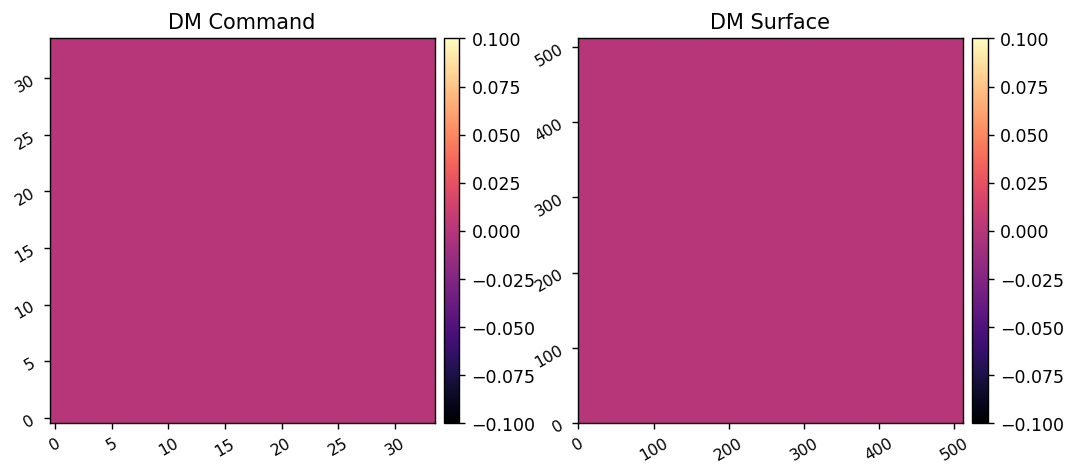

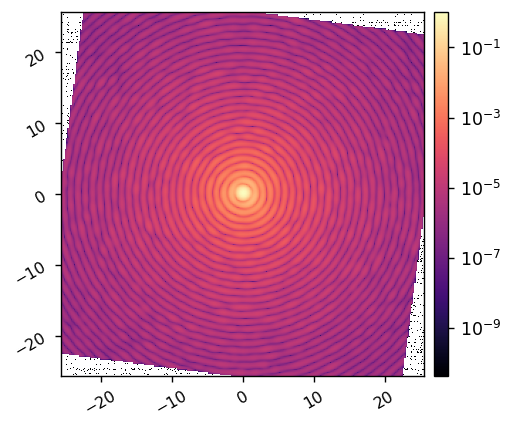

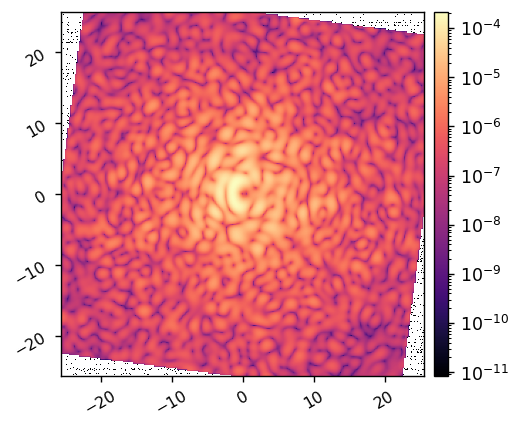

In [2]:
reload(scoob)
model = scoob.SCOOBM(npix=npix, 
                      oversample=oversample, 
                     npsf=256,
                      wavelength=wavelength_c, 
                      pupil_diam=pupil_diam,
                      det_rotation=det_rotation, 
                      use_synthetic_opds=True,
#                       dm_ref=dm_flat,
                     )

model.show_dm()

im0 = model.snap()
model.Imax_ref = im0.max()

ref_unocc_im = model.snap(plot=True)

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap(plot=True)

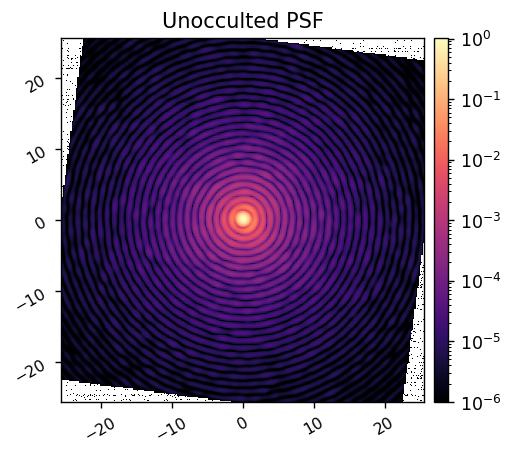

In [9]:
imshow1(ref_unocc_im, 'Unocculted PSF',  pxscl=model.psf_pixelscale_lamD, lognorm=True, vmin=1e-6)

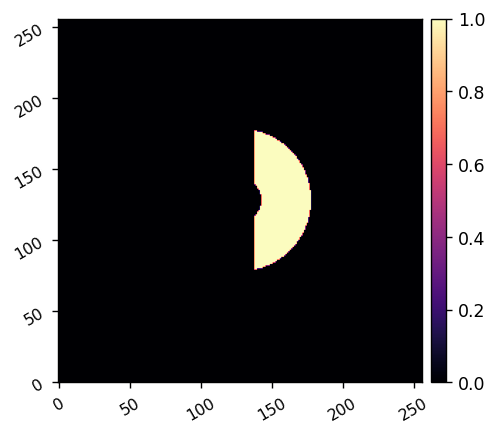

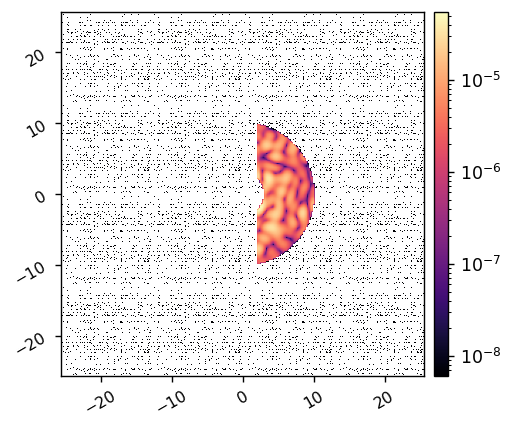

In [3]:
reload(lina.utils)
iwa = 3
owa = 10

control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=2, shift=(0,0), rotation=0, plot=True)
imshow1(ref_im*control_mask, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [4]:
reload(lina.efc)

model.reset_dm()
epsilon = 1e-9 # poke amplitudes (DM surface)
jac = lina.efc.build_jacobian(model, epsilon, control_mask, plot=False)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=1155.040 sec.
Jacobian built in 1155.040 sec


In [12]:
reload(lina.utils)
lina.utils.save_fits('jac.fits', jac)

Saved data to:  jac.fits


In [37]:
xp.sqrt(xp.sum(xp.abs(responses)**2, axis=0)).shape

(952,)

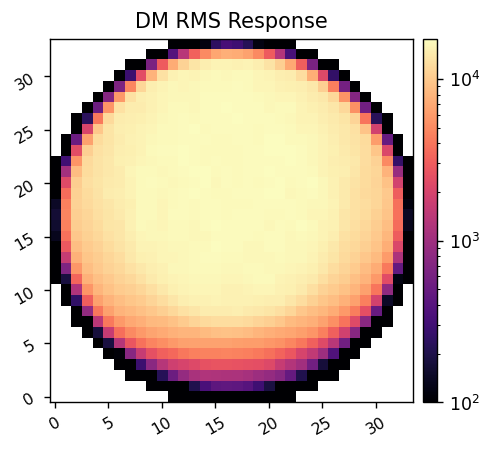

In [11]:
reload(lina.utils)
# response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)

responses = jac[::2] + 1j*jac[1::2]
dm_response = model.map_acts_to_dm(xp.sqrt(xp.mean(xp.abs(responses)**2, axis=0)))
imshow1(dm_response, 'DM RMS Response', lognorm=True, vmin=1e2)

Beginning closed-loop EFC simulation.
Max singular value squared:	 5188906635402.639
alpha^2:			 898451282025.7445

	Running iteration 1/5.


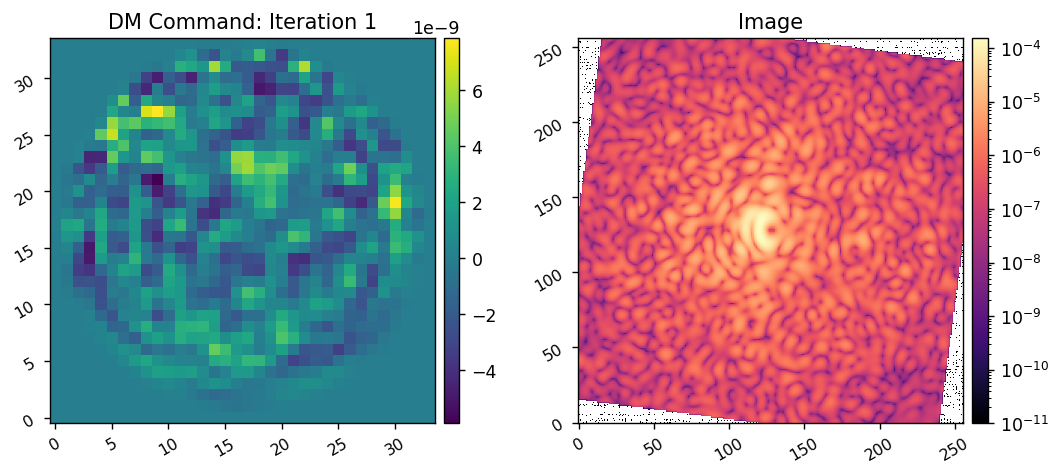

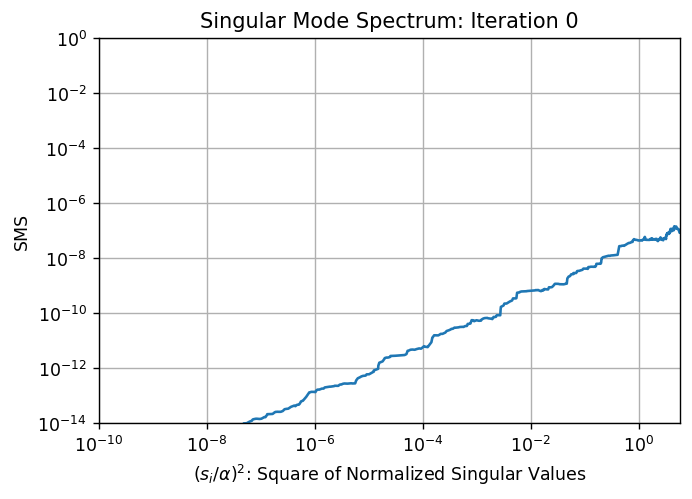

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


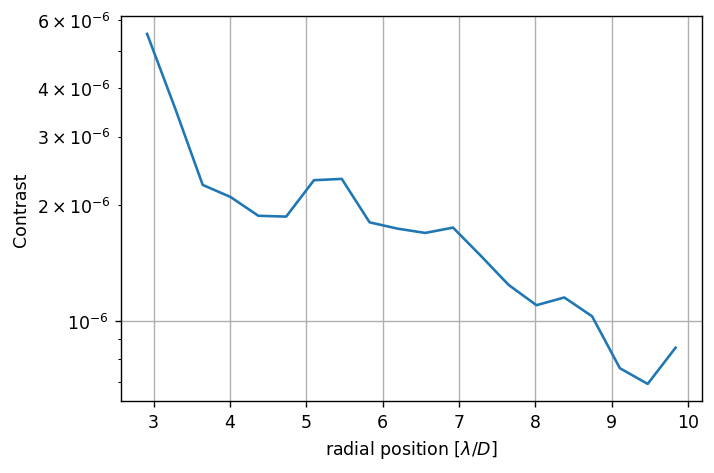

	Running iteration 2/5.


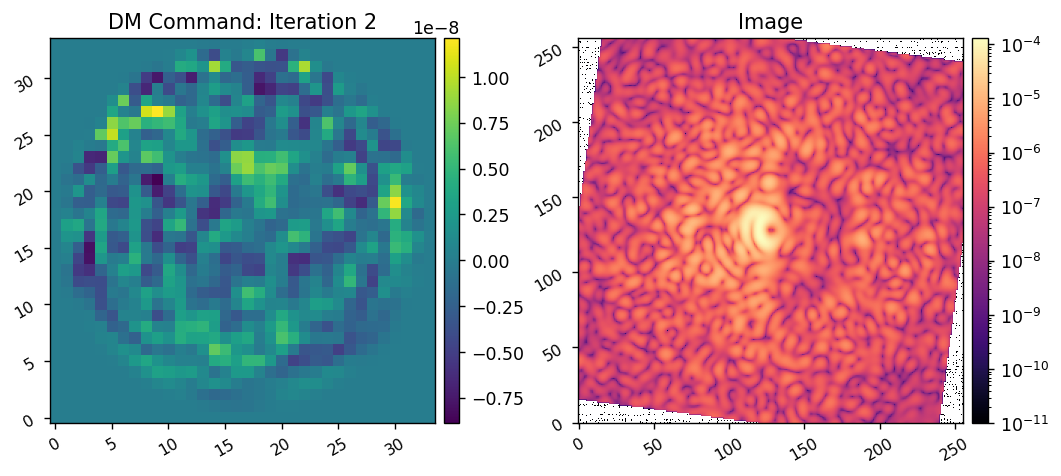

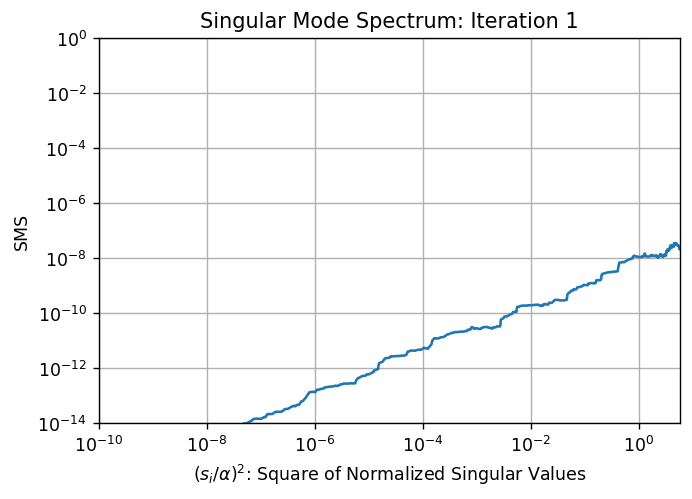

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


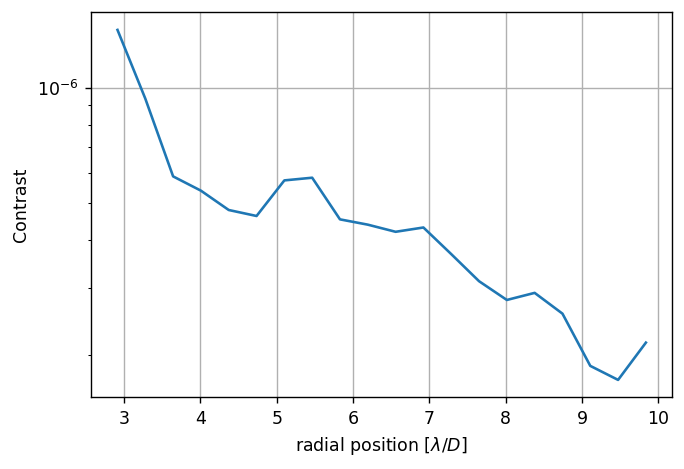

	Running iteration 3/5.


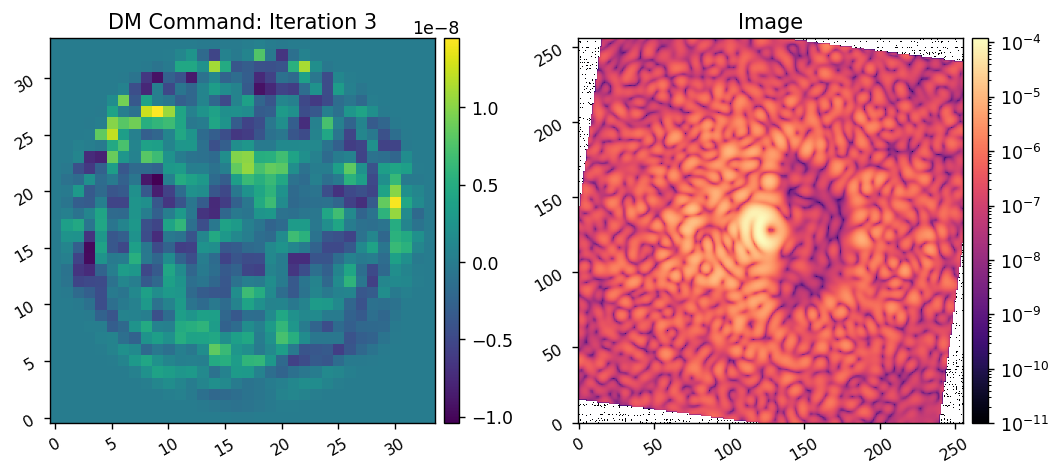

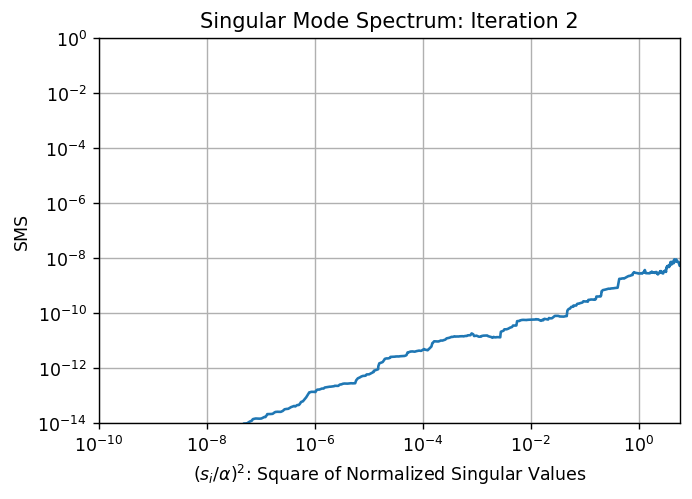

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


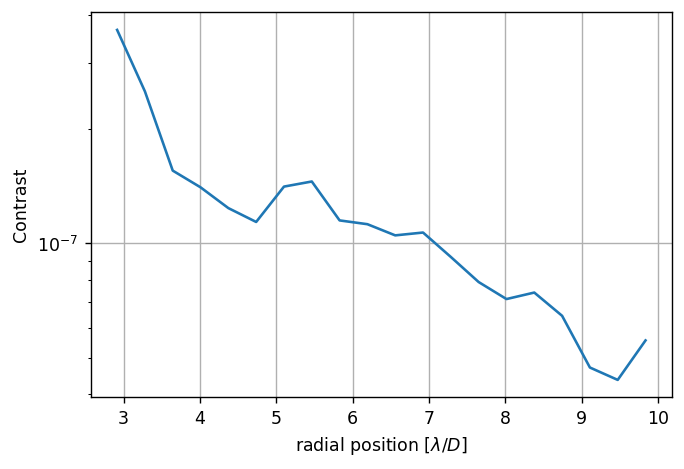

	Running iteration 4/5.


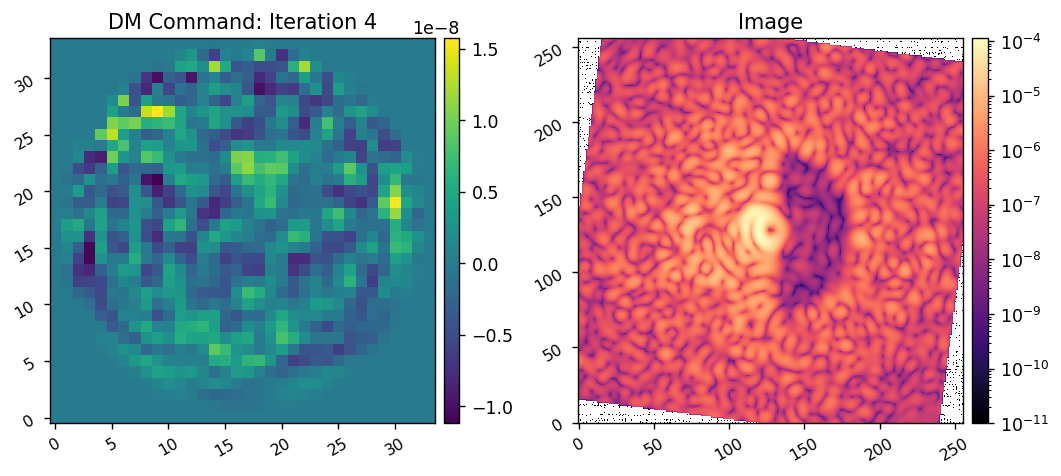

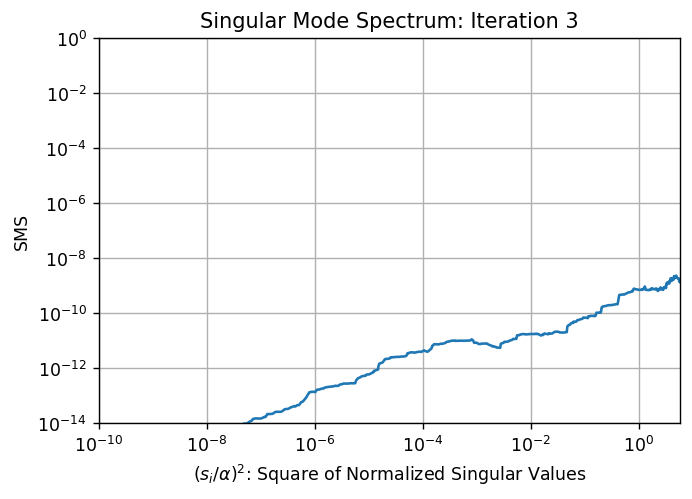

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


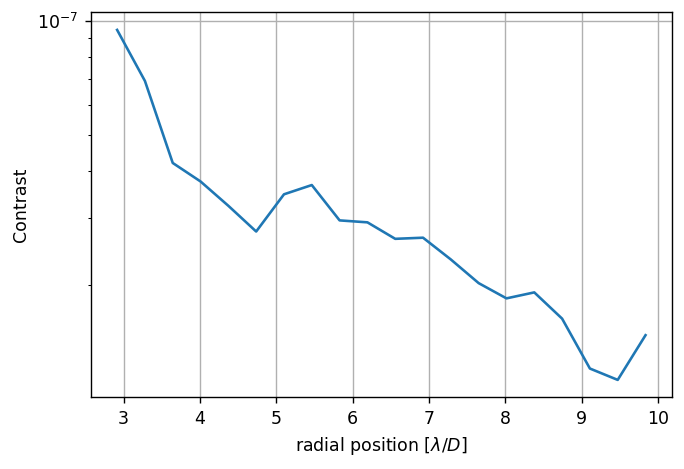

	Running iteration 5/5.


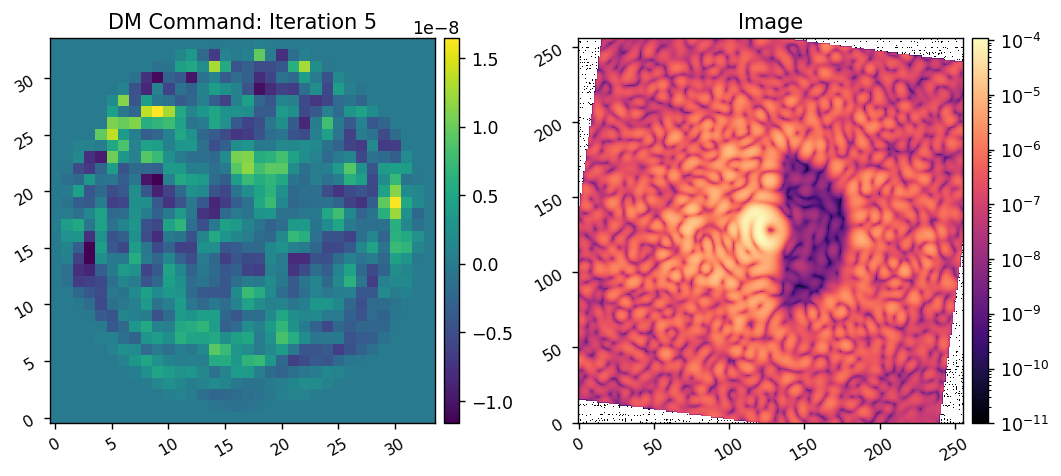

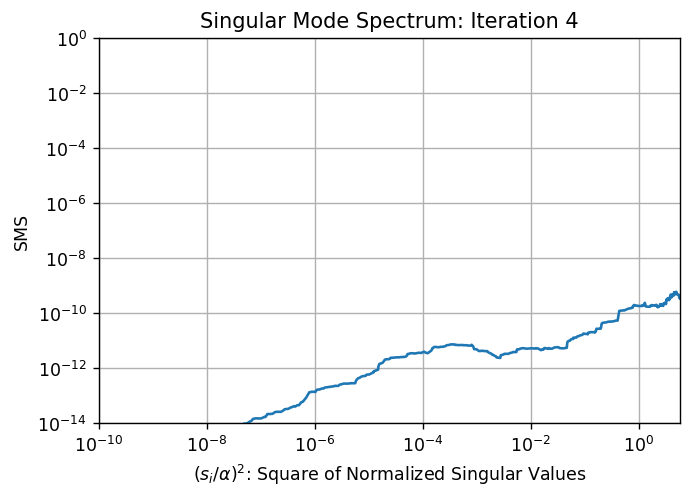

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


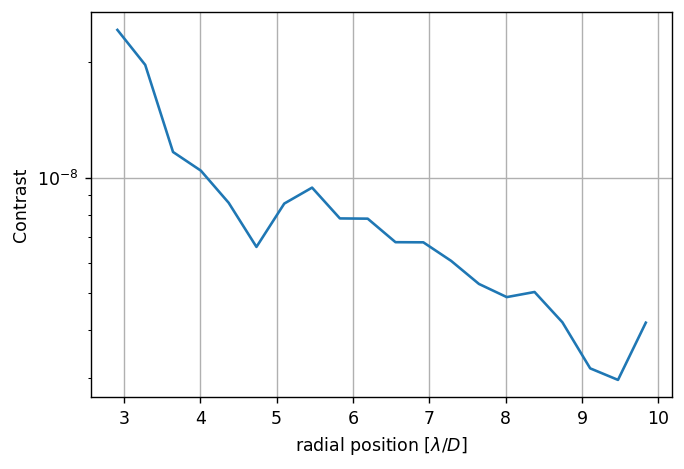

EFC completed in 8.619 sec.


In [14]:
reload(lina.efc)
model.reset_dm()

control_matrix = lina.utils.beta_reg(jac, -3)

images, efields,commands = lina.efc.run_efc_perfect(model, 
                                                    jac, 
                                                    control_matrix,
                                                    control_mask, 
                                                    Imax_unocc=1, # pre-normalized the model
                                                    efc_loop_gain=0.5, 
                                                    iterations=5, 
                                                    plot_all=True, 
                                                    plot_sms=True,
                                                     plot_radial_contrast=True)

Beginning closed-loop EFC simulation.
Max singular value squared:	 5188906635402.639
alpha^2:			 898451282025.7445

	Running iteration 1/5.


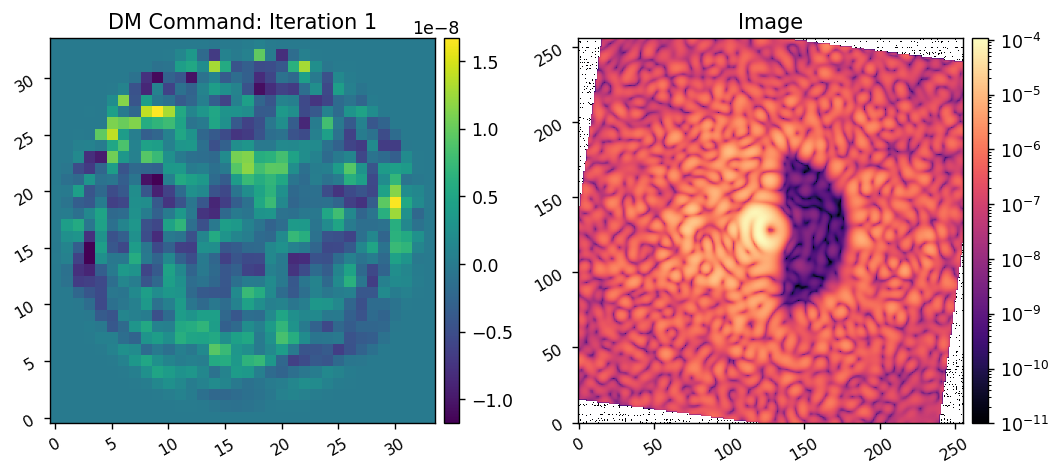

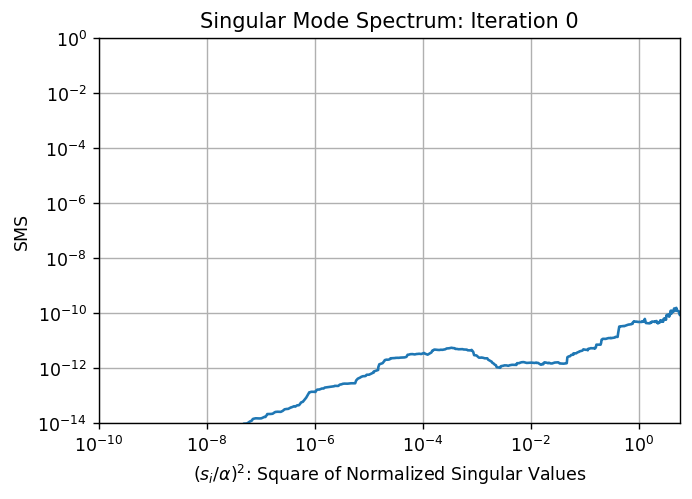

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


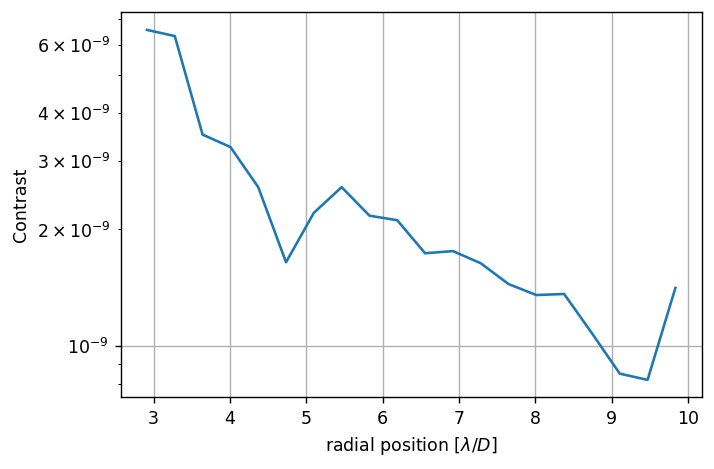

	Running iteration 2/5.


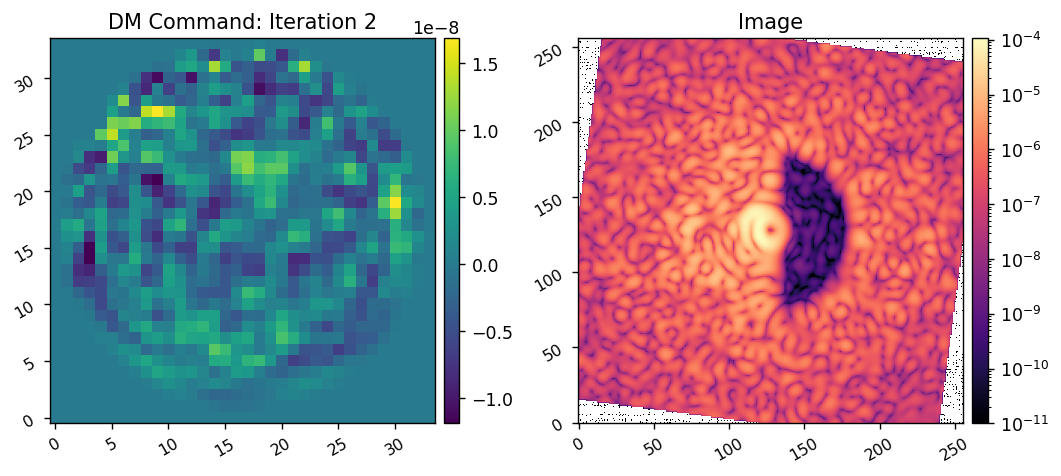

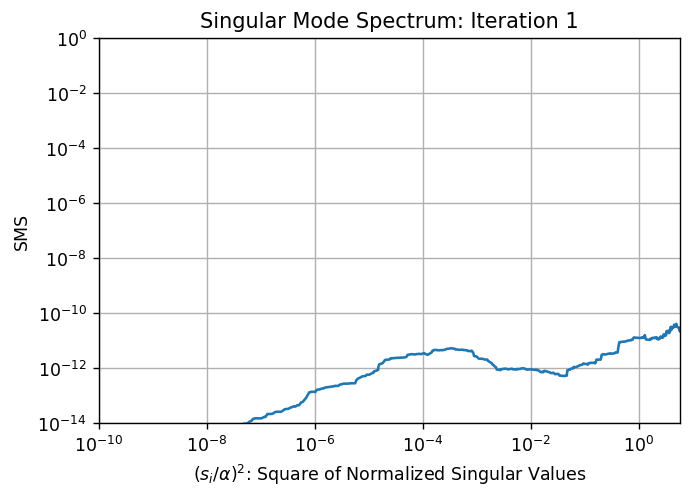

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


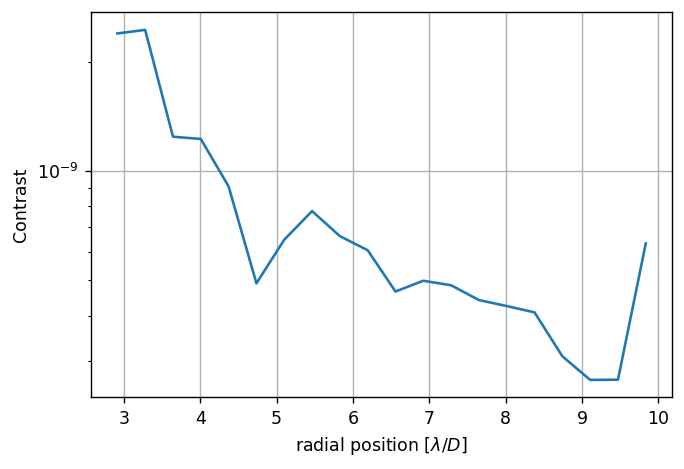

	Running iteration 3/5.


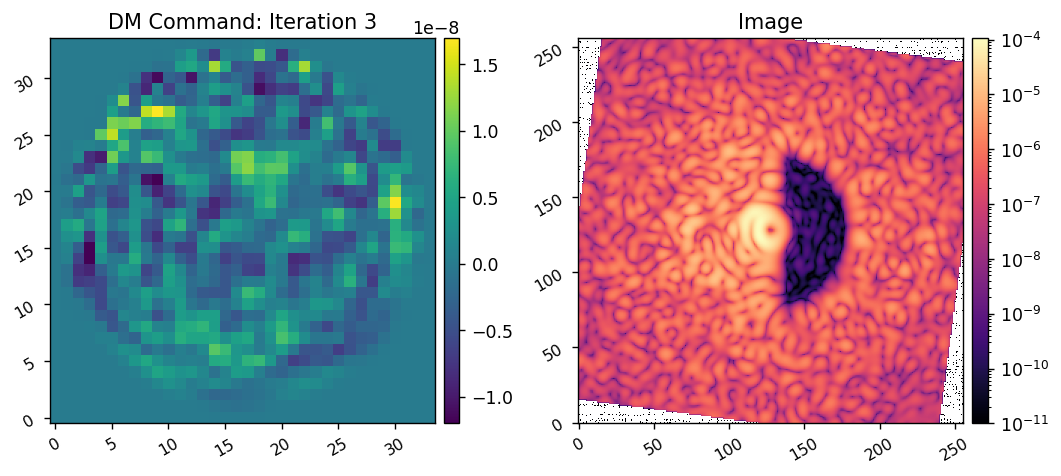

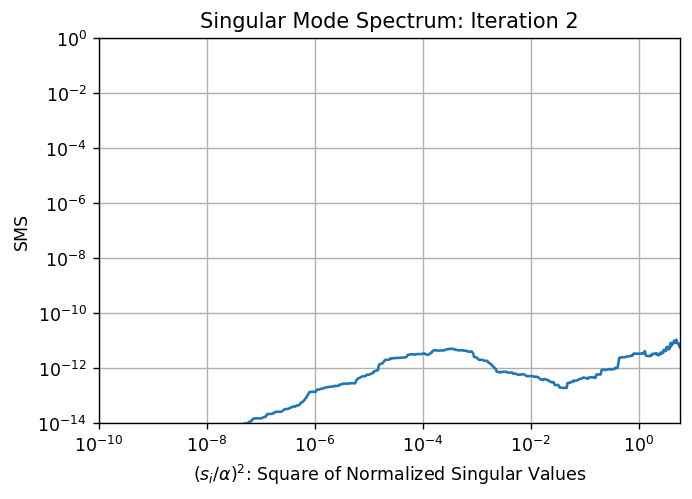

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


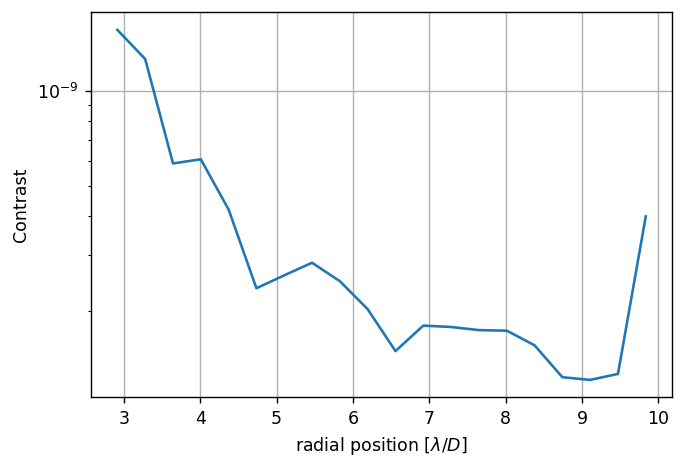

	Running iteration 4/5.


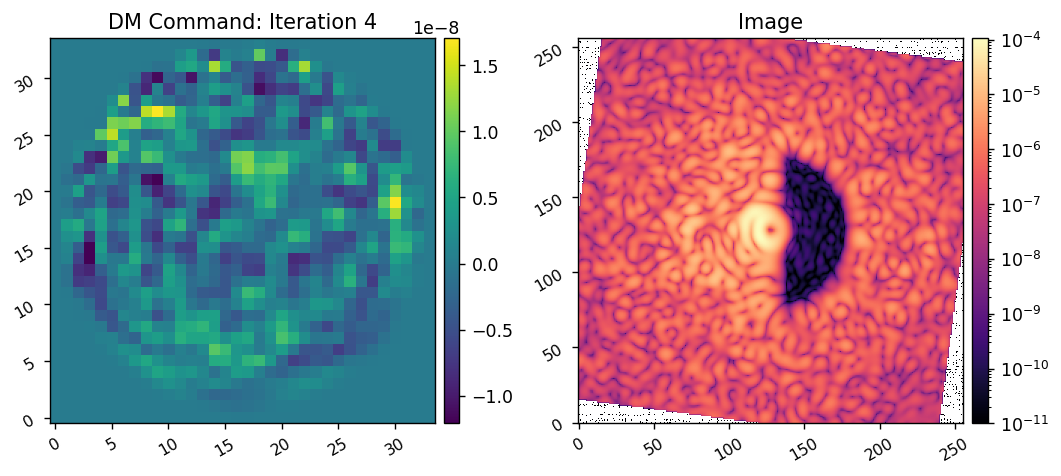

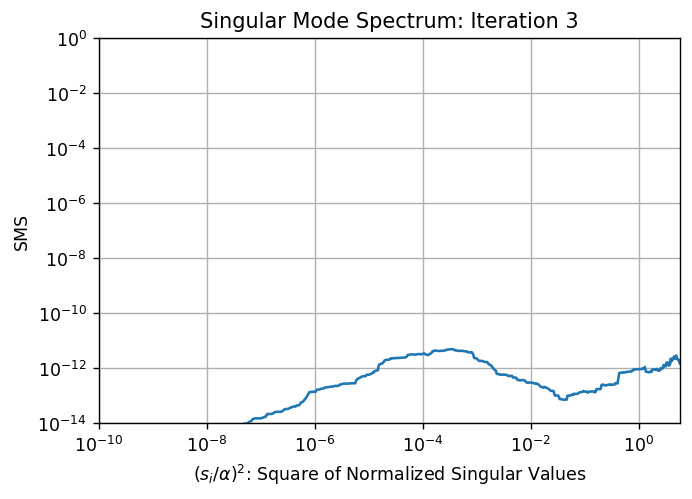

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


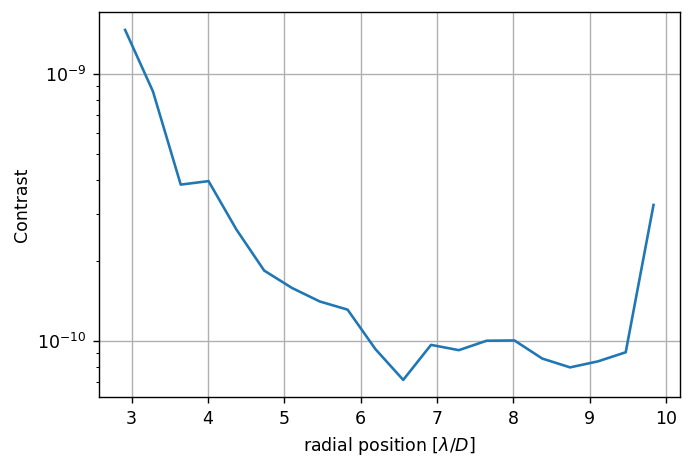

	Running iteration 5/5.


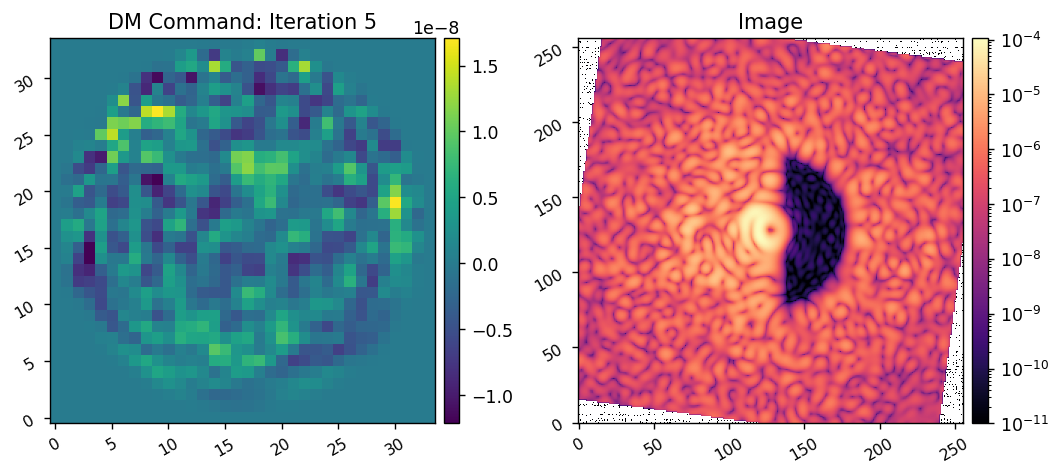

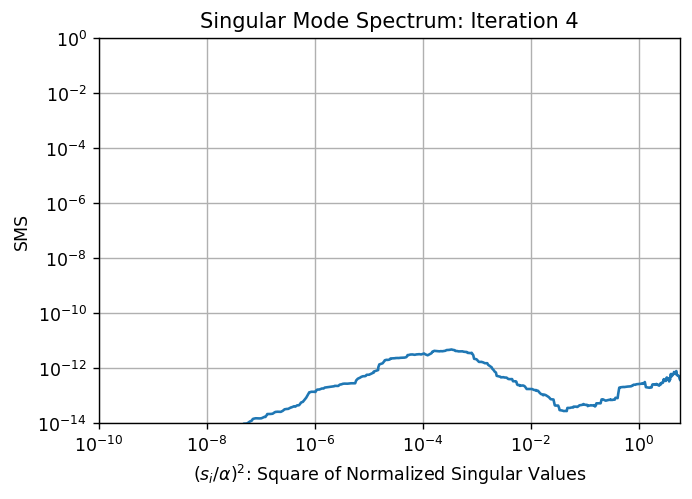

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


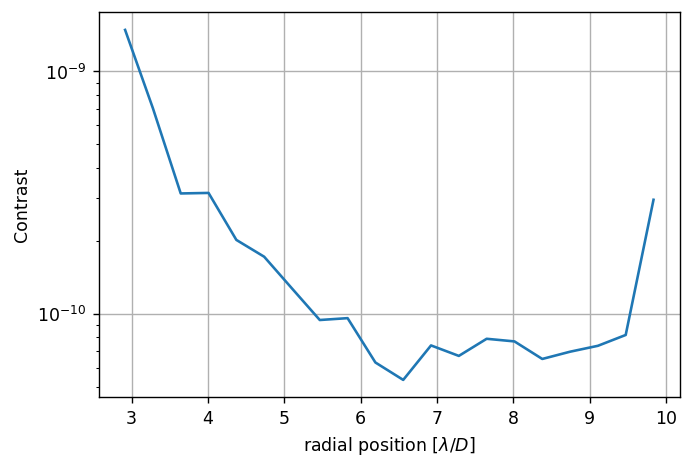

EFC completed in 8.705 sec.


In [15]:
reload(lina.efc)

control_matrix = lina.utils.beta_reg(jac, -2)

images, efields,commands = lina.efc.run_efc_perfect(model, 
                                                    jac, 
                                                    control_matrix,
                                                    control_mask, 
                                                    Imax_unocc=1, # pre-normalized the model
                                                    efc_loop_gain=0.5, 
                                                    iterations=5, 
                                                    plot_all=True, 
                                                    plot_sms=True,
                                                     plot_radial_contrast=True)

In [ ]:
imshow2(commands[-1], images[-1], lognorm2=True,)